In [1]:
import sys
import glob
import os
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

In [2]:
# Read data
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

# formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

In [3]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

# calc the 12 day means for each site: 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()


In [4]:
# Drop the non interpolated landsat bands
cols = [c for c in df.columns if 'filt' not in c]
df=df[cols]

In [5]:
# One hot encode the landcover types *** figure this out
# df = df.lc_type.astype(str)
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')
df = rdf.dropna()
df.columns = df.columns.map(str)

In [6]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

s3 = df.groupby(level="site").shift(3)
df3 = df2.join(s3.rename(columns=lambda x: x+"_t3"))

In [7]:
# Drop unnecessary cols 

In [8]:
dropstrs = ['site','precip', 'rzsm_', 'ssm', 'psi_rz', "psi_s"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)

In [9]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [17]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.000000001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= "Nadam",
                  metrics=['mse'])
    
    return model


In [18]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

Processing 2119
Train on 2873 samples, validate on 45 samples
Epoch 1/100
 - 1s - loss: 0.0875 - mse: 0.0875 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 2/100
 - 0s - loss: 0.0715 - mse: 0.0715 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 3/100
 - 0s - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/100
 - 0s - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 5/100
 - 0s - loss: 0.0391 - mse: 0.0391 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 6/100
 - 0s - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 7/100
 - 0s - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/100
 - 0s - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 9/100
 - 0s - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 10/100
 - 0s - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 11/100
 - 0s - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 12/100

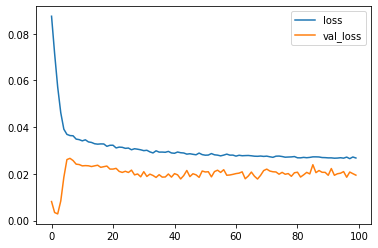

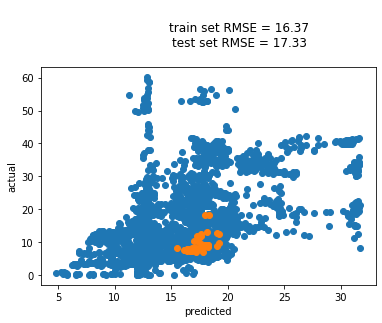

Processing 2121
Train on 2867 samples, validate on 51 samples
Epoch 1/100
 - 1s - loss: 0.1009 - mse: 0.1009 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 2/100
 - 0s - loss: 0.0852 - mse: 0.0852 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 3/100
 - 0s - loss: 0.0713 - mse: 0.0713 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 4/100
 - 0s - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 5/100
 - 0s - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/100
 - 0s - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/100
 - 0s - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/100
 - 0s - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 9/100
 - 0s - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 10/100
 - 0s - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 11/100
 - 0s - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 12/100

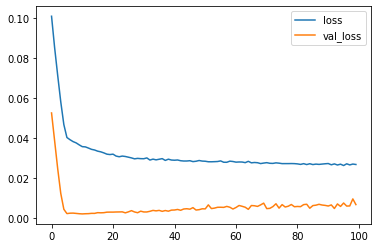

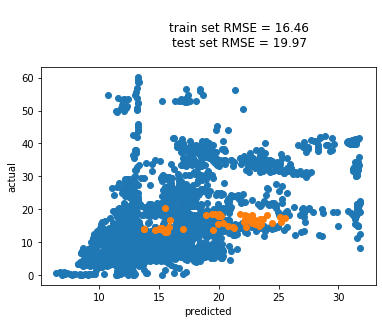

Processing 2125
Train on 2875 samples, validate on 43 samples
Epoch 1/100
 - 1s - loss: 0.0977 - mse: 0.0977 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 2/100
 - 0s - loss: 0.0819 - mse: 0.0819 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 3/100
 - 0s - loss: 0.0676 - mse: 0.0676 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 4/100
 - 0s - loss: 0.0548 - mse: 0.0548 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/100
 - 0s - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/100
 - 0s - loss: 0.0402 - mse: 0.0402 - val_loss: 5.2686e-04 - val_mse: 5.2683e-04
Epoch 7/100
 - 0s - loss: 0.0386 - mse: 0.0386 - val_loss: 1.9969e-04 - val_mse: 1.9965e-04
Epoch 8/100
 - 0s - loss: 0.0381 - mse: 0.0381 - val_loss: 2.5623e-04 - val_mse: 2.5620e-04
Epoch 9/100
 - 0s - loss: 0.0374 - mse: 0.0374 - val_loss: 3.6545e-04 - val_mse: 3.6542e-04
Epoch 10/100
 - 0s - loss: 0.0371 - mse: 0.0371 - val_loss: 6.0841e-04 - val_mse: 6.0838e-04
Epoch 11/100
 - 0s - loss: 0.0364 - mse: 0.0364 - val_los

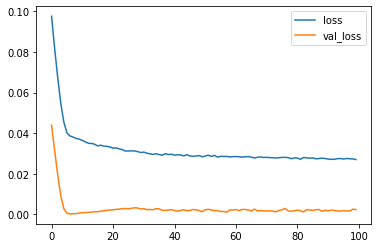

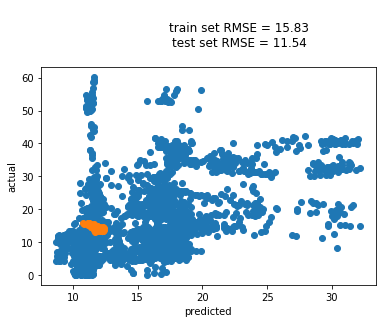

Processing 2126
Train on 2866 samples, validate on 52 samples
Epoch 1/100
 - 1s - loss: 0.1072 - mse: 0.1072 - val_loss: 0.1711 - val_mse: 0.1711
Epoch 2/100
 - 0s - loss: 0.0916 - mse: 0.0916 - val_loss: 0.1445 - val_mse: 0.1445
Epoch 3/100
 - 0s - loss: 0.0777 - mse: 0.0777 - val_loss: 0.1157 - val_mse: 0.1157
Epoch 4/100
 - 0s - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0847 - val_mse: 0.0847
Epoch 5/100
 - 0s - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 6/100
 - 0s - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 7/100
 - 0s - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 8/100
 - 0s - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 9/100
 - 0s - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 10/100
 - 0s - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 11/100
 - 0s - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 12/100

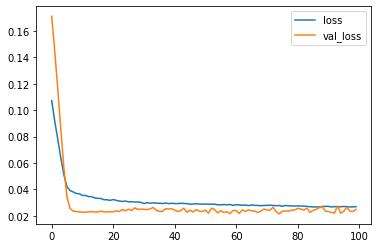

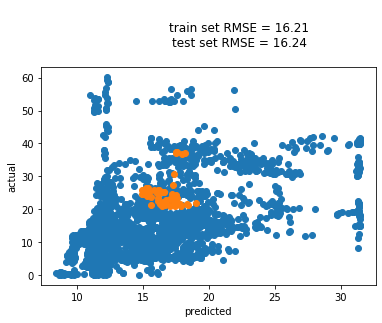

Processing 2127
Train on 2873 samples, validate on 45 samples
Epoch 1/100
 - 2s - loss: 0.0860 - mse: 0.0860 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 2/100
 - 0s - loss: 0.0666 - mse: 0.0666 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3/100
 - 0s - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/100
 - 0s - loss: 0.0427 - mse: 0.0427 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/100
 - 0s - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 6/100
 - 0s - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 7/100
 - 0s - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/100
 - 0s - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 9/100
 - 0s - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 10/100
 - 0s - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 11/100
 - 0s - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 12/100

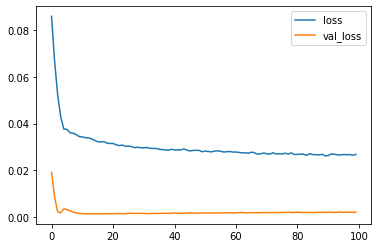

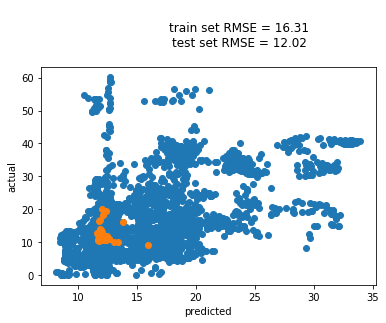

Processing 2128
Train on 2865 samples, validate on 53 samples
Epoch 1/100
 - 2s - loss: 0.0970 - mse: 0.0970 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 2/100
 - 0s - loss: 0.0832 - mse: 0.0832 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 3/100
 - 0s - loss: 0.0709 - mse: 0.0709 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 4/100
 - 0s - loss: 0.0585 - mse: 0.0585 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 5/100
 - 0s - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 6/100
 - 0s - loss: 0.0429 - mse: 0.0429 - val_loss: 1.2940e-04 - val_mse: 1.2937e-04
Epoch 7/100
 - 0s - loss: 0.0404 - mse: 0.0404 - val_loss: 1.4769e-04 - val_mse: 1.4766e-04
Epoch 8/100
 - 0s - loss: 0.0404 - mse: 0.0404 - val_loss: 1.3850e-04 - val_mse: 1.3847e-04
Epoch 9/100
 - 0s - loss: 0.0383 - mse: 0.0383 - val_loss: 9.8133e-05 - val_mse: 9.8102e-05
Epoch 10/100
 - 0s - loss: 0.0375 - mse: 0.0375 - val_loss: 9.7969e-05 - val_mse: 9.7938e-05
Epoch 11/100
 - 0s - loss: 0.0363 - mse: 0.0363 - val_los

KeyboardInterrupt: 

In [19]:
for i in df.site.unique()[15:]:

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.rzsm
    X_test = sdf.drop(["site","rzsm"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.rzsm 
    X_train = nsdf.drop(["site","rzsm"], axis=1)
        
    # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
    transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 4
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 19))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 19))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 100,
                    batch_size=1000,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mse']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()


    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [ ]:
train_history.history.keys()

In [ ]:
for i in df.site.unique():
    sdf = df[df.site == i]
    max_len = 0
    if len(sdf)>max_len:
        max_len = len(sdf)
        answer = i
    else:
        continue

In [ ]:
answer